In [1]:
import cvxpy as cvx
import numpy as np
import pandas as pd

%matplotlib inline

# Exploratory data analysis

In [2]:
items = pd.read_csv('breakfast_items.csv', index_col='item')

In [3]:
items

,energy,fat,saturated_fat,carbs,sugar,fibre,protein,salt,cost
item,,,,,,,,,
Almonds,5.8700,0.4900,0.0370,0.0950,0.0390,0.1200,0.2100,0.0000,0.010000
Bananas,1.0300,0.0030,0.0010,0.2320,0.2090,0.0110,0.0120,0.0001,0.000760
"Blueberries, frozen",0.4480,0.0020,0.0000,0.0910,0.0910,0.0150,0.0090,0.0000,0.005000
Cashews,5.8169,0.4385,0.0778,0.2689,0.0591,0.0330,0.1822,0.0003,0.011000
Corn flakes,3.8639,0.0114,0.0030,0.8515,0.0661,0.0253,0.0761,0.0068,0.001933
Granola,4.2980,0.1340,0.0490,0.6410,0.1890,0.0680,0.0980,0.0003,0.002000
"Greek yogurt, 0% fat",0.5700,0.0000,0.0000,0.0400,0.0400,0.0000,0.1030,0.0010,0.005500
"Greek yogurt, full fat",0.9600,0.0500,0.0360,0.0380,0.0380,0.0000,0.0900,0.0010,0.005500
Honey,3.2611,0.0001,0.0001,0.8100,0.8100,0.0001,0.0050,0.0010,0.005294


## Bar plot of energy per gram

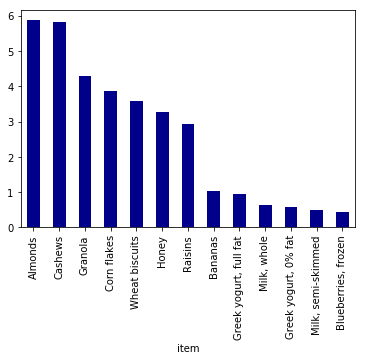

In [4]:
items['energy'].sort_values(ascending=False).plot.bar(color='darkblue')

## Bar plot of cost per gram

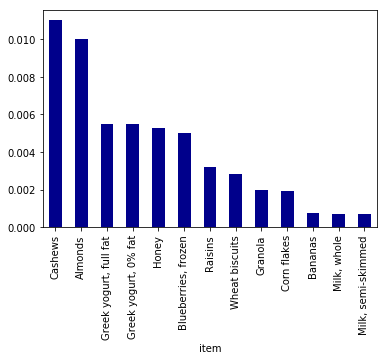

In [5]:
items['cost'].sort_values(ascending=False).plot.bar(color='darkblue')

## Bar plot of energy per pound sterling

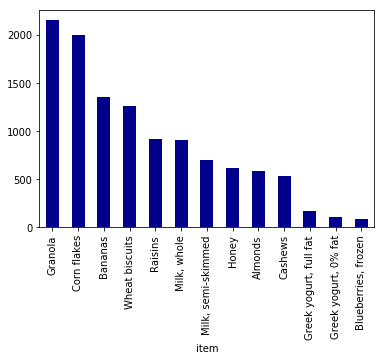

In [6]:
(items['energy'] / items['cost']).sort_values(ascending=False).plot.bar(color='darkblue')

# Modelling

Define the decisions variables representing the amounts (in gram) for each product.

In [7]:
x = cvx.Variable(items.shape[0], nonneg=True)

Define some constraints on energy and nutrients.

In [8]:
total_energy = 2500 / 4
max_fat = total_energy * 0.35 / 9
max_saturated_fat = total_energy * 0.11 / 9
max_carbs = total_energy * 0.5 / 4
max_sugar = total_energy * 0.05 / 4
min_fibre = 30 / 4
min_protein = 70 * 0.75 / 4
max_salt = 6 / 4

In [9]:
constraints = [
    cvx.sum(x * items['energy']) == total_energy,
    cvx.sum(x * items['fat']) <= max_fat,
    cvx.sum(x * items['saturated_fat']) <= max_saturated_fat,
    cvx.sum(x * items['carbs']) <= max_carbs,
    cvx.sum(x * items['sugar']) <= max_sugar,
    cvx.sum(x * items['fibre']) >= min_fibre,
    cvx.sum(x * items['protein']) >= min_protein,
    cvx.sum(x * items['salt']) <= max_salt,
]

Define and solve the problem of minimising total cost subject to `constraints`.

In [10]:
problem = cvx.Problem(cvx.Minimize(cvx.sum(x * items['cost'])), constraints)

In [11]:
problem.solve()

0.7146726594868881

Check the solution.

In [12]:
pd.DataFrame({'quantity': np.round(x.value, 2)}, index=items.index).sort_values('quantity', ascending=False)

,quantity
item,
Wheat biscuits,107.69
Almonds,39.81
Honey,0.60
Raisins,0.57
Bananas,0.31
"Greek yogurt, full fat",0.26
"Milk, whole",0.19
"Milk, semi-skimmed",0.15
Granola,0.14


In [13]:
pd.DataFrame({'value': x.value @ items}, index=items.columns)

,value
energy,624.999835
fat,21.739658
saturated_fat,2.148955
carbs,78.163149
sugar,7.312004
fibre,15.576357
protein,21.384204
salt,0.304289
cost,0.714673
